/Users/aaryannagpal1/Documents/Thesis/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
10904/10904 ━━━━━━━━━━━━━━━━━━━━ 9s 705us/step - accuracy: 0.9593 - loss: 0.1118 - val_accuracy: 0.9652 - val_loss: 0.0869
Epoch 2/50
10904/10904 ━━━━━━━━━━━━━━━━━━━━ 7s 662us/step - accuracy: 0.9671 - loss: 0.0895 - val_accuracy: 0.9700 - val_loss: 0.0767
Epoch 3/50
10904/10904 ━━━━━━━━━━━━━━━━━━━━ 8s 719us/step - accuracy: 0.9683 - loss: 0.0854 - val_accuracy: 0.9704 - val_loss: 0.0748
Epoch 4/50
10904/10904 ━━━━━━━━━━━━━━━━━━━━ 8s 688us/step - accuracy: 0.9688 - loss: 0.0829 - val_accuracy: 0.9689 - val_loss: 0.0743
Epoch 5/50
10904/10904 ━━━━━━━━━━━━━━━━━━━━ 7s 663us/step - accuracy: 0.9689 - loss: 0.0814 - val_accuracy: 0.9717 - val_loss: 0.0721
Epoch 6/50
10904/10904 ━━━━━━━━━━━━━━━━━━━━ 7s 680us/step - accuracy: 0.9694 - loss: 0.0804 - val_accuracy: 0.9692 - val_loss: 0.0718
Epoch 7/50
10904/10904 ━━━━━━━━━━━━━━━━━━━━ 7s 651us/step - accuracy: 0.9692 - loss: 0.0790 - val_accuracy: 0.9710 - val_loss: 0.0694
Epoch 8/50
10904/10904 ━━━━━━━━━━━━━━━━━━━━ 7s 676us/step - ac

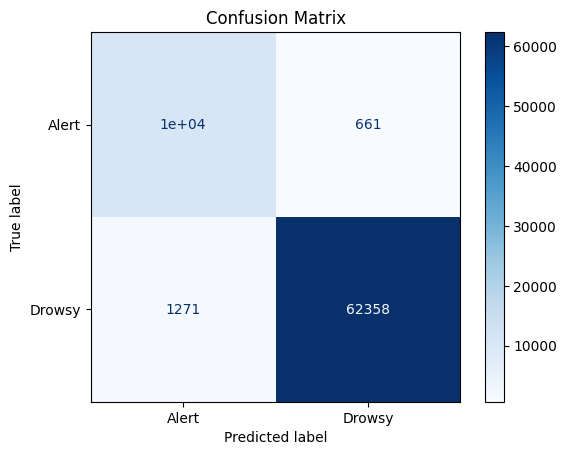

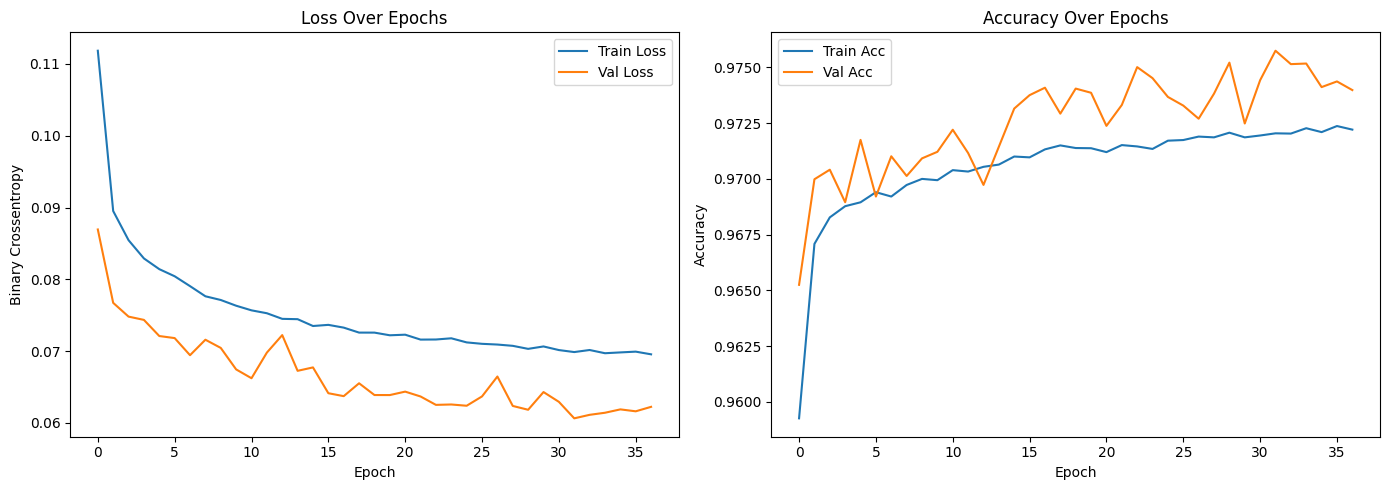

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# -----------------------------
# Load and preprocess data
# -----------------------------
df = pd.read_csv("Raw Data/P8_S1.csv")

# Drop 1back and 2back
df = df[~df['Label'].isin(['1back', '2back'])].dropna(subset=['Label'])

# Binary label
df['binary_label'] = df['Label'].apply(lambda x: 1 if x in ['slightly', 'moderately', 'very'] else 0)

# Predictors and label
features = ['Physio_ECG','Physio_GSR','swAngle','laneDev_OffsetfrmLaneCentre','speed']
X = df[features]
y = df['binary_label'].values

# Scale and reshape
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_cnn = X_scaled.reshape(-1, X.shape[1], 1)

# Train/Val/Test Split
X_temp, X_test, y_temp, y_test = train_test_split(X_cnn, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)

# -----------------------------
# CNN Model Definition
# -----------------------------
model = Sequential([
    Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_cnn.shape[1], 1)),
    BatchNormalization(),

    Conv1D(64, kernel_size=2, activation='relu'),
    BatchNormalization(),

    # Only one pooling layer
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# -----------------------------
# Train Model
# -----------------------------
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# -----------------------------
# Evaluation and Confusion Matrix
# -----------------------------
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

y_pred = (model.predict(X_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Alert", "Drowsy"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# -----------------------------
# Training Curves
# -----------------------------
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()